# Final Project - Azka Nur Afifah

Part II

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
import seaborn as sns
import re
import matplotlib.dates as mdates
from datetime import datetime
sns.set()
from collections import Counter

import sys
sys.path.append(r'C:\Users\azuka\Documents\Python Scripts\common_functions')
from common_functions import check_values, make_connection, update_sheet, get_sheet, replace_columns

In [3]:
import statsmodels.formula.api as smf
from scipy.special import expit, logit

In [4]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from 
    :return df: <pandas DataFrame> 
    """
    coef = results.params
    std_err = results.bse
    
    df = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df

# load data

In [5]:
df_married = pd.read_csv('df_raw_ever_married.csv')
df_married.shape

(36926, 35)

In [6]:
import pickle 

# with open('saved_value_list.pkl', 'wb') as f:
#     pickle.dump(vl, f)
        
with open('saved_value_list.pkl', 'rb') as f:
    vl = pickle.load(f)

In [7]:
df_married.columns

Index(['caseid', 'hhid', 'v012', 'v013', 'v022', 'v024', 'v025', 's108',
       'v106', 'v130', 'v201', 'v212', 'v228', 'v625a', 'v626a', 'v632',
       'v632a', 'v501', 'v502', 'v511', 'v512', 'v513', 'v133', 'v149', 'v190',
       'v191', 'v744a', 'v744b', 'v744c', 'v744d', 'v744e', 'beatings_lvl',
       'beatings', 'ever_married', 'child_marriage'],
      dtype='object')

In [8]:
vl['V149']

{0: 'no education',
 1: 'incomplete primary',
 2: 'complete primary',
 3: 'incomplete secondary',
 4: 'complete secondary',
 5: 'higher'}

In [9]:
df_married.v149.map(vl['V149']).value_counts()

complete secondary      10155
incomplete secondary     9010
complete primary         8033
higher                   5371
incomplete primary       3549
no education              808
Name: v149, dtype: int64

In [10]:
df_married['is_hs_grad'] = np.where(df_married.v149.isin([4,5]),1,0)
df_married.is_hs_grad.value_counts()

0    21400
1    15526
Name: is_hs_grad, dtype: int64

In [11]:
df_married['is_rural'] = np.where(df_married.v025=='rural',1,0)
df_married.is_rural.value_counts()

0    18735
1    18191
Name: is_rural, dtype: int64

We'll only take women born in 1990 and after (MZ generation), which in 2017 would be max 27 years old.

In [134]:
selected_cols = ['caseid','beatings','child_marriage','is_rural', 'v191', 'is_hs_grad']
df_data = df_married[(df_married.v012<=27)][selected_cols].reset_index(drop=True).rename(columns={'v191':'wealth_index'})
df_data.shape

(7265, 6)

<AxesSubplot:ylabel='Frequency'>

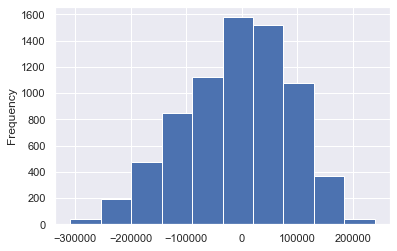

In [13]:
df_data.wealth_index.plot.hist()

In [135]:
df_data['wealth_score'] = df_data.wealth_index / 100_000

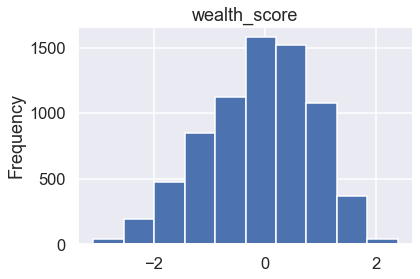

In [209]:
df_data.wealth_score.plot.hist()
plt.title('wealth_score')
plt.savefig('wealth_score_hist.png'.replace(' ','_'), bbox_inches='tight')

Here we are making an interaction term, using is_hs_grad and child_marriage

The new term, poor_edu_sup reflects a poor education support from a woman's environment

In [138]:
df_data['poor_edu_sup'] = np.where(df_data.is_hs_grad==0,1,0)*df_data.child_marriage

# Modelling

In [54]:
sns.set_context('talk')

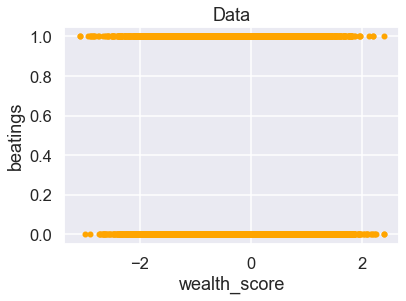

In [55]:
plt.scatter(df_data.wealth_score, df_data.beatings, color = 'orange', marker='.')

plt.xlabel('wealth_score')
plt.ylabel('beatings')

plt.title("Data")
plt.show()

In [136]:
df_data['beatings_label'] = np.where(df_data.beatings==1,'yes','no')

<AxesSubplot:xlabel='wealth_score', ylabel='beatings_label'>

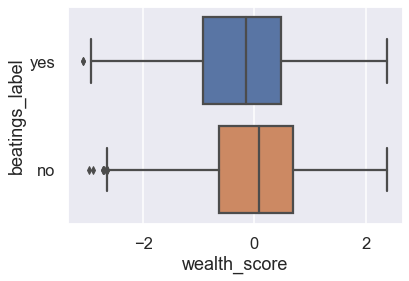

In [137]:
sns.boxplot(y = 'beatings_label', x = 'wealth_score', data = df_data)

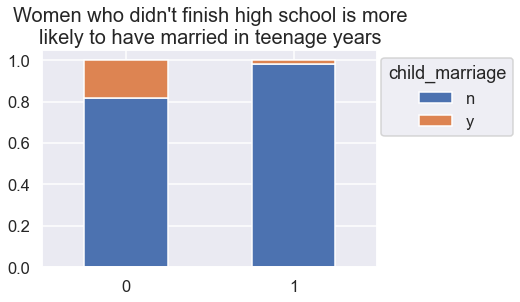

In [188]:
df_data.groupby('is_hs_grad')['child_marriage'].value_counts(normalize=True).unstack('child_marriage').plot.bar(stacked=True)
plt.xticks(rotation=0)
plt.xlabel('')
plt.title("Women who didn't finish high school is more\nlikely to have married in teenage years", fontdict={'fontsize':20})
plt.legend(['n','y'], title='child_marriage',bbox_to_anchor=(1.43, 1),loc="upper right")
plt.savefig('is_hs_grad_child_marriage.png'.replace(' ','_'), bbox_inches='tight')
plt.show()

## Benchmark model: 1 predictor

### 1 predictor: wealth score

In [167]:
def lr_model_fit(relationship:str):
    lr = smf.logit(relationship, df_data)
    lr_model = lr.fit()
    return print_coef_std_err(lr_model), lr_model

In [189]:
results_base_coef, model_base_coef = lr_model_fit('beatings ~ wealth_score')
results_base_coef

Optimization terminated successfully.
         Current function value: 0.658719
         Iterations 4


,coef,std err
Intercept,-0.498464,0.024995
wealth_score,-0.265135,0.026077


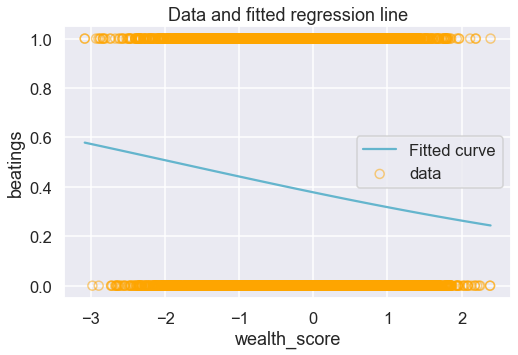

In [190]:

predictor = 'wealth_score'
outcome = 'beatings'
data = df_data.copy()
results_ = results_base_coef.copy()

# Plot the data
plt.figure(figsize=(8,5))
plt.scatter(data[predictor], data[outcome], marker= 'o', facecolors = "none", edgecolor="orange", alpha=0.5, label='data')

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

# get values from predictor range
x_range = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 100)

# predicted probabilities of x in x_range
pred_prob = expit(a_hat + b_hat*x_range)

# Plot the fitted line
plt.plot(x_range, pred_prob, label="Fitted curve", color = "c")

# Add a legend and labels
plt.legend()
plt.ylabel(outcome)
plt.xlabel(predictor)

# Add a title and adjust the margins
plt.title("Data and fitted regression line")
plt.savefig('fitted_curve_1pred.png'.replace(' ','_'), bbox_inches='tight')

# Show the plot
plt.show()

In [23]:
results_base_coef

,coef,std err
Intercept,-0.498464,0.024995
wealth_score,-0.265135,0.026077


$$P(\text{beatings}) = \text{logit}^{-1}(-0.498 + -0.265\text{wealth\_score})$$

- Negative coefficient indicates that higher wealth_score tends to have lower probability of acceptance of wife beating.
- A one-unit change in wealth_score corresponds to 6.63% (0.265135/4) negative difference in probability of acceptance of wife beating
- Considering that moving up by 1 wealth score is like moving to a an entirely better economic class, a difference of -6.63% in probability of acceptance of wife beating is not practically significant. There's a lot of factors involved for someone to move up to better economic class.

### 1 interaction term: poor_edu_sup

In [192]:
results_base_coef2, model_base_coef2 = lr_model_fit('beatings ~ poor_edu_sup')

Optimization terminated successfully.
         Current function value: 0.665034
         Iterations 4


In [143]:
results_base_coef2

,coef,std err
Intercept,-0.502531,0.025876
poor_edu_sup,0.341554,0.083724


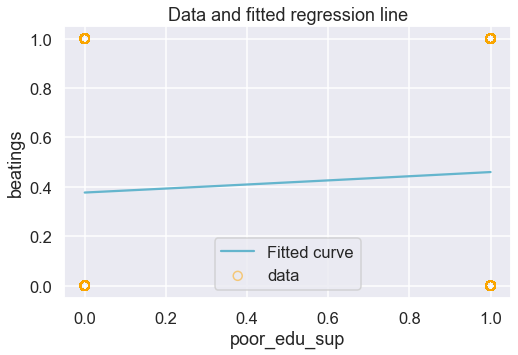

In [193]:

predictor = 'poor_edu_sup'
outcome = 'beatings'
data = df_data.copy()
results_ = results_base_coef2.copy()

# Plot the data
plt.figure(figsize=(8,5))
plt.scatter(data[predictor], data[outcome], marker= 'o', facecolors = "none", edgecolor="orange", alpha=0.5, label='data')

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

# get values from predictor range
x_range = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 100)

# predicted probabilities of x in x_range
pred_prob = expit(a_hat + b_hat*x_range)

# Plot the fitted line
plt.plot(x_range, pred_prob, label="Fitted curve", color = "c")

# Add a legend and labels
plt.legend()
plt.ylabel(outcome)
plt.xlabel(predictor)

# Add a title and adjust the margins
plt.title("Data and fitted regression line")
plt.savefig('fitted_curve_1pred2.png'.replace(' ','_'), bbox_inches='tight')

# Show the plot
plt.show()

In [131]:
results_base_coef2

,coef,std err
Intercept,-0.502531,0.025876
poor_education,0.341554,0.083724


$$P(\text{beatings}) = \text{logit}^{-1}(-0.5025 + 0.34155\text{poor\_edu\_sup})$$

- Positive coefficient indicates that higher value of poor_edu_sup (=has poor education support) tends to have higher probability of acceptance of wife beating.
- Women with poor education support (not finished high school and married as a teenager) have 8.54% (0.34155/4) positive difference in probability of acceptance of wife beating
- The standard error is smaller than the coefficient of poor_edu_support

## Benchmark model: 2 predictors

### 2 Predictors (wealth_score & is_rural)

In [172]:
results_2pred_coef, model_2pred_coef = lr_model_fit('beatings ~ wealth_score + is_rural')

Optimization terminated successfully.
         Current function value: 0.658587
         Iterations 4


In [99]:
results_2pred_coef

,coef,std err
Intercept,-0.538206,0.038543
wealth_score,-0.247011,0.029265
is_rural,0.076057,0.055936


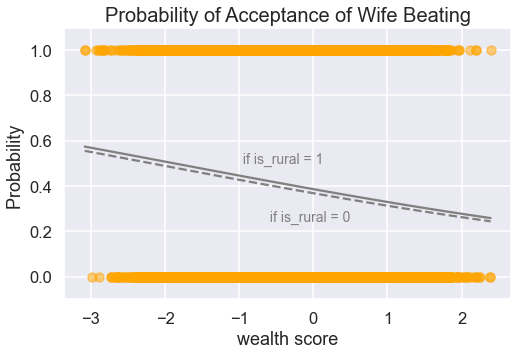

In [195]:

b0_hat = results_2pred_coef["coef"]["Intercept"]
b1_hat = results_2pred_coef["coef"]["wealth_score"]
b2_hat = results_2pred_coef["coef"]["is_rural"]

# Create the plot

fig, ax = plt.subplots(figsize=(8, 5))

# Plot the data
ax.scatter(df_data["wealth_score"], df_data["beatings"], marker='o', color='orange', alpha=0.5)

# Range of dist100 variable
x_range = np.linspace(np.min(df_data["wealth_score"]), np.max(df_data["wealth_score"]), 100)

# Plot logistic regression line, given arsenic level = 1
ax.plot(x_range, expit(b0_hat + b1_hat*x_range + b2_hat*1), color='gray')

# Plot logistic regression line, given arsenic level = 0.5
ax.plot(x_range, expit(b0_hat + b1_hat*x_range + b2_hat*0), linestyle='--', color='gray')

ax.text(0.5, 0.23, f" if is_rural = 0", color='gray', ha='right', va='bottom', fontsize=14)
ax.text(-1.0, 0.55, f" if is_rural = 1", color='gray', ha='left', va='top', fontsize=14)

ax.set(xlabel='wealth score', ylabel='Probability ', ylim=[-0.1, 1.1])
ax.set_title('Probability of Acceptance of Wife Beating',fontdict={'fontsize':20})

plt.savefig('fitted_curve_2pred_1.png'.replace(' ','_'), bbox_inches='tight')
plt.show()

Women living in rural areas don't really have higher probability of accepting wife beating when compared with women in urban areas.

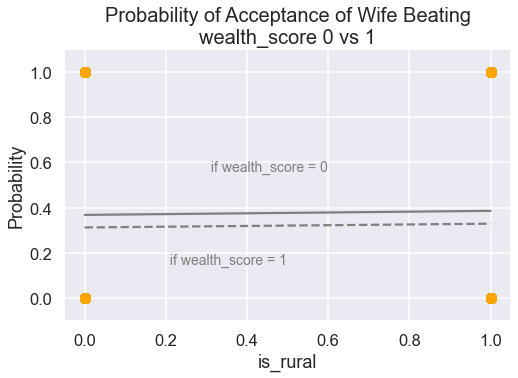

In [196]:

b0_hat = results_2pred_coef["coef"]["Intercept"]
b1_hat = results_2pred_coef["coef"]["wealth_score"]
b2_hat = results_2pred_coef["coef"]["is_rural"]

# Create the plot

fig, ax = plt.subplots(figsize=(8, 5))

# Plot the data
ax.scatter(df_data["is_rural"], df_data["beatings"], marker='o', color='orange', alpha=0.5)

# Range of dist100 variable
x_range = np.linspace(np.min(df_data["is_rural"]), np.max(df_data["is_rural"]), 100)

# Plot logistic regression line, given distance = 0
ax.plot(x_range, expit(b0_hat + b1_hat*0 + b2_hat*x_range), color='gray')

# Plot logistic regression line, given distance = 50, remember our coefficient in term dist/100, so set 0.5 as the input
ax.plot(x_range, expit(b0_hat + b1_hat*1 + b2_hat*x_range), linestyle='--', color='gray')

ax.text(0.6, 0.55, f" if wealth_score = 0", color='gray', ha='right', va='bottom', fontsize=14)
ax.text(0.2, 0.2, f" if wealth_score = 1", color='gray', ha='left', va='top', fontsize=14)

ax.set(xlabel='is_rural', ylabel='Probability', ylim=[-0.1, 1.1])
ax.set_title('Probability of Acceptance of Wife Beating\nwealth_score 0 vs 1',fontdict={'fontsize':20})


plt.savefig('fitted_curve_2pred_2.png'.replace(' ','_'), bbox_inches='tight')
plt.show()

Women who are in household with lower economic levels have higher probability to accept wife beating, but by only so much. 

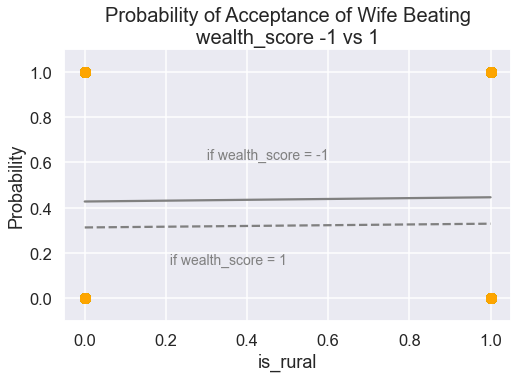

In [197]:

b0_hat = results_2pred_coef["coef"]["Intercept"]
b1_hat = results_2pred_coef["coef"]["wealth_score"]
b2_hat = results_2pred_coef["coef"]["is_rural"]

# Create the plot

fig, ax = plt.subplots(figsize=(8, 5))

# Plot the data
ax.scatter(df_data["is_rural"], df_data["beatings"], marker='o', color='orange', alpha=0.5)

# Range of dist100 variable
x_range = np.linspace(np.min(df_data["is_rural"]), np.max(df_data["is_rural"]), 100)

# Plot logistic regression line, given distance = 0
ax.plot(x_range, expit(b0_hat + b1_hat*-1 + b2_hat*x_range), color='gray')

# Plot logistic regression line, given distance = 50, remember our coefficient in term dist/100, so set 0.5 as the input
ax.plot(x_range, expit(b0_hat + b1_hat*1 + b2_hat*x_range), linestyle='--', color='gray')

ax.text(0.6, 0.6, f" if wealth_score = -1", color='gray', ha='right', va='bottom', fontsize=14)
ax.text(0.2, 0.2, f" if wealth_score = 1", color='gray', ha='left', va='top', fontsize=14)

ax.set(xlabel='is_rural', ylabel='Probability', ylim=[-0.1, 1.1])
ax.set_title('Probability of Acceptance of Wife Beating\nwealth_score -1 vs 1',fontdict={'fontsize':20})

plt.savefig('fitted_curve_2pred_3.png'.replace(' ','_'), bbox_inches='tight')
plt.show()

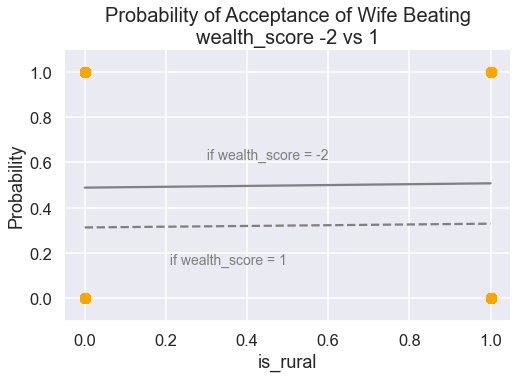

In [198]:

b0_hat = results_2pred_coef["coef"]["Intercept"]
b1_hat = results_2pred_coef["coef"]["wealth_score"]
b2_hat = results_2pred_coef["coef"]["is_rural"]

# Create the plot

fig, ax = plt.subplots(figsize=(8, 5))

# Plot the data
ax.scatter(df_data["is_rural"], df_data["beatings"], marker='o', color='orange', alpha=0.5)

# Range of dist100 variable
x_range = np.linspace(np.min(df_data["is_rural"]), np.max(df_data["is_rural"]), 100)

# Plot logistic regression line, given distance = 0
ax.plot(x_range, expit(b0_hat + b1_hat*-2 + b2_hat*x_range), color='gray')

# Plot logistic regression line, given distance = 50, remember our coefficient in term dist/100, so set 0.5 as the input
ax.plot(x_range, expit(b0_hat + b1_hat*1 + b2_hat*x_range), linestyle='--', color='gray')

ax.text(0.6, 0.6, f" if wealth_score = -2", color='gray', ha='right', va='bottom', fontsize=14)
ax.text(0.2, 0.2, f" if wealth_score = 1", color='gray', ha='left', va='top', fontsize=14)

ax.set(xlabel='is_rural', ylabel='Probability', ylim=[-0.1, 1.1])
ax.set_title('Probability of Acceptance of Wife Beating\nwealth_score -2 vs 1',fontdict={'fontsize':20})


plt.savefig('fitted_curve_2pred_4.png'.replace(' ','_'), bbox_inches='tight')
plt.show()

The difference in probability of wife beating acceptance is more pronounced when women move up by 3 wealth score, which sounds quite unthinkable. 

In [202]:
results_2pred_coef

,coef,std err
Intercept,-0.538206,0.038543
wealth_score,-0.247011,0.029265
is_rural,0.076057,0.055936


$$P(\text{beatings}) = \text{logit}^{-1}(-0.538 - 0.247\text{wealth\_score} + 0.076\text{is\_rural})$$

- Coefficient for wealth score is bigger than the standard error, while coefficient for is_rural is only slightly bigger than the standard error.
- When a woman move up by 1 wealth score, it corresponds to 6.175% (0.247 / 4) lower probability of accepting of wife beating
- Meanwhile, when a women is living in urban areas (is_rural decreases by 1, is_rural = 0) only corresponds to 1.9% (0.076/4) lower probability of accepting of wife beating.


### 2 predictors (wealth_score & poor_edu_sup)

poor_edu_sup is an interaction term between non_hs_graduate ( of is_hs_graduate) and child_marriage 

In [173]:
results_2pred_int_coef, model_2pred_int_coef = lr_model_fit('beatings ~ wealth_score + poor_edu_sup')

Optimization terminated successfully.
         Current function value: 0.658361
         Iterations 4


In [149]:
results_2pred_int_coef

,coef,std err
Intercept,-0.515269,0.026126
wealth_score,-0.254531,0.026501
poor_edu_sup,0.192015,0.085622


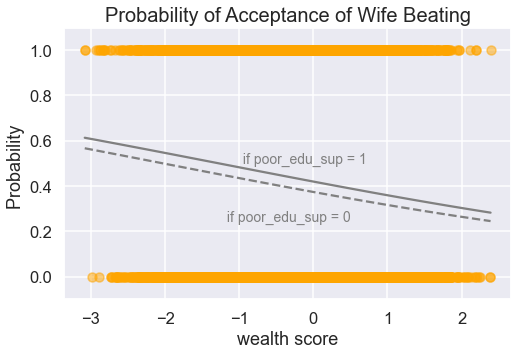

In [203]:

b0_hat = results_2pred_int_coef["coef"]["Intercept"]
b1_hat = results_2pred_int_coef["coef"]["wealth_score"]
b2_hat = results_2pred_int_coef["coef"]["poor_edu_sup"]

# Create the plot

fig, ax = plt.subplots(figsize=(8, 5))

# Plot the data
ax.scatter(df_data["wealth_score"], df_data["beatings"], marker='o', color='orange', alpha=0.5)

# Range of dist100 variable
x_range = np.linspace(np.min(df_data["wealth_score"]), np.max(df_data["wealth_score"]), 100)

# Plot logistic regression line, given arsenic level = 1
ax.plot(x_range, expit(b0_hat + b1_hat*x_range + b2_hat*1), color='gray')

# Plot logistic regression line, given arsenic level = 0.5
ax.plot(x_range, expit(b0_hat + b1_hat*x_range + b2_hat*0), linestyle='--', color='gray')

ax.text(0.5, 0.23, f" if poor_edu_sup = 0", color='gray', ha='right', va='bottom', fontsize=14)
ax.text(-1.0, 0.55, f" if poor_edu_sup = 1", color='gray', ha='left', va='top', fontsize=14)

ax.set(xlabel='wealth score', ylabel='Probability ', ylim=[-0.1, 1.1])
ax.set_title('Probability of Acceptance of Wife Beating',fontdict={'fontsize':20})

plt.savefig('fitted_curve_2pred2_1.png'.replace(' ','_'), bbox_inches='tight')

plt.show()

For women in the same household wealth score, women with poorer education support tend to have higher probability of accepting of wife beating.

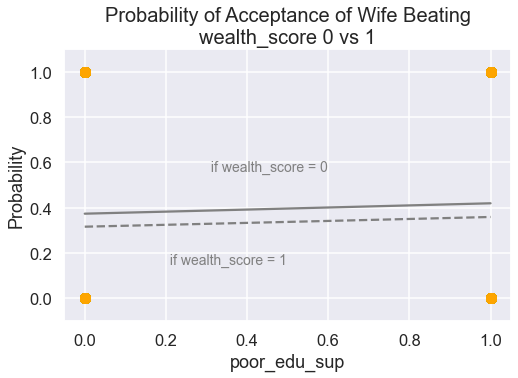

In [204]:

b0_hat = results_2pred_int_coef["coef"]["Intercept"]
b1_hat = results_2pred_int_coef["coef"]["wealth_score"]
b2_hat = results_2pred_int_coef["coef"]["poor_edu_sup"]

# Create the plot

fig, ax = plt.subplots(figsize=(8, 5))

# Plot the data
ax.scatter(df_data["poor_edu_sup"], df_data["beatings"], marker='o', color='orange', alpha=0.5)

# Range of dist100 variable
x_range = np.linspace(np.min(df_data["poor_edu_sup"]), np.max(df_data["poor_edu_sup"]), 100)

# Plot logistic regression line, given distance = 0
ax.plot(x_range, expit(b0_hat + b1_hat*0 + b2_hat*x_range), color='gray')

# Plot logistic regression line, given distance = 50, remember our coefficient in term dist/100, so set 0.5 as the input
ax.plot(x_range, expit(b0_hat + b1_hat*1 + b2_hat*x_range), linestyle='--', color='gray')

ax.text(0.6, 0.55, f" if wealth_score = 0", color='gray', ha='right', va='bottom', fontsize=14)
ax.text(0.2, 0.2, f" if wealth_score = 1", color='gray', ha='left', va='top', fontsize=14)

ax.set(xlabel='poor_edu_sup', ylabel='Probability', ylim=[-0.1, 1.1])
ax.set_title('Probability of Acceptance of Wife Beating\nwealth_score 0 vs 1',fontdict={'fontsize':20})

plt.savefig('fitted_curve_2pred2_2.png'.replace(' ','_'), bbox_inches='tight')
plt.show()

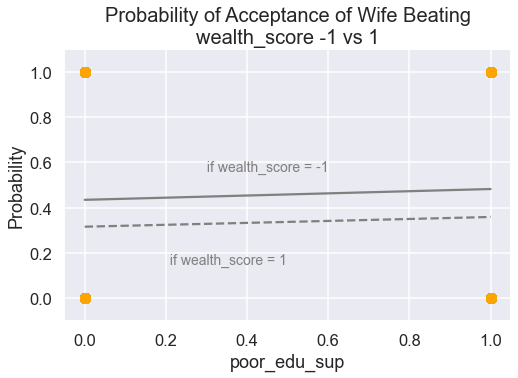

In [205]:

b0_hat = results_2pred_int_coef["coef"]["Intercept"]
b1_hat = results_2pred_int_coef["coef"]["wealth_score"]
b2_hat = results_2pred_int_coef["coef"]["poor_edu_sup"]

# Create the plot

fig, ax = plt.subplots(figsize=(8, 5))

# Plot the data
ax.scatter(df_data["poor_edu_sup"], df_data["beatings"], marker='o', color='orange', alpha=0.5)

# Range of dist100 variable
x_range = np.linspace(np.min(df_data["poor_edu_sup"]), np.max(df_data["poor_edu_sup"]), 100)

# Plot logistic regression line, given distance = 0
ax.plot(x_range, expit(b0_hat + b1_hat*-1 + b2_hat*x_range), color='gray')

# Plot logistic regression line, given distance = 50, remember our coefficient in term dist/100, so set 0.5 as the input
ax.plot(x_range, expit(b0_hat + b1_hat*1 + b2_hat*x_range), linestyle='--', color='gray')

ax.text(0.6, 0.55, f" if wealth_score = -1", color='gray', ha='right', va='bottom', fontsize=14)
ax.text(0.2, 0.2, f" if wealth_score = 1", color='gray', ha='left', va='top', fontsize=14)

ax.set(xlabel='poor_edu_sup', ylabel='Probability', ylim=[-0.1, 1.1])
ax.set_title('Probability of Acceptance of Wife Beating\nwealth_score -1 vs 1',fontdict={'fontsize':20})

plt.savefig('fitted_curve_2pred2_3.png'.replace(' ','_'), bbox_inches='tight')
plt.show()

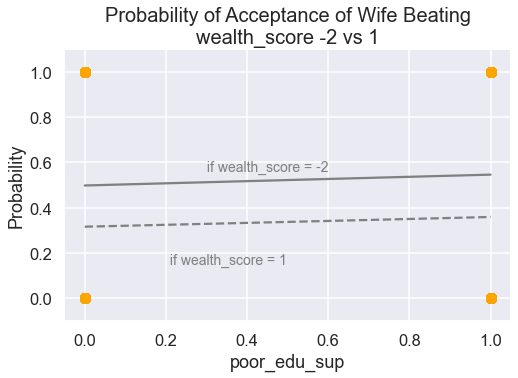

In [206]:

b0_hat = results_2pred_int_coef["coef"]["Intercept"]
b1_hat = results_2pred_int_coef["coef"]["wealth_score"]
b2_hat = results_2pred_int_coef["coef"]["poor_edu_sup"]

# Create the plot

fig, ax = plt.subplots(figsize=(8, 5))

# Plot the data
ax.scatter(df_data["poor_edu_sup"], df_data["beatings"], marker='o', color='orange', alpha=0.5)

# Range of dist100 variable
x_range = np.linspace(np.min(df_data["poor_edu_sup"]), np.max(df_data["poor_edu_sup"]), 100)

# Plot logistic regression line, given distance = 0
ax.plot(x_range, expit(b0_hat + b1_hat*-2 + b2_hat*x_range), color='gray')

# Plot logistic regression line, given distance = 50, remember our coefficient in term dist/100, so set 0.5 as the input
ax.plot(x_range, expit(b0_hat + b1_hat*1 + b2_hat*x_range), linestyle='--', color='gray')

ax.text(0.6, 0.55, f" if wealth_score = -2", color='gray', ha='right', va='bottom', fontsize=14)
ax.text(0.2, 0.2, f" if wealth_score = 1", color='gray', ha='left', va='top', fontsize=14)

ax.set(xlabel='poor_edu_sup', ylabel='Probability', ylim=[-0.1, 1.1])
ax.set_title('Probability of Acceptance of Wife Beating\nwealth_score -2 vs 1',fontdict={'fontsize':20})

plt.savefig('fitted_curve_2pred2_4.png'.replace(' ','_'), bbox_inches='tight')
plt.show()

For women with the same education support, having access to a higher wealth score corresponds to lower probability of accepting of wife beating.

In [207]:
print(results_2pred_int_coef)

                  coef   std err
Intercept    -0.515269  0.026126
wealth_score -0.254531  0.026501
poor_edu_sup  0.192015  0.085622


$$P(\text{beatings}) = \text{logit}^{-1}(-0.538 - 0.2545\text{wealth\_score} + 0.192\text{poor\_edu\_sup})$$

- Coefficient for wealth score is bigger than the standard error, while coefficient for poor_edu_sup is only slightly bigger than the standard error.
- When a woman move up by 1 wealth score, it corresponds to 6.365% (0.2545 / 4) lower probability of accepting of wife beating
- Meanwhile, when a women have better education support during their teenage years only corresponds to 4.8% (0.192/4) lower probability of accepting of wife beating


## Evaluation

### Log score for null model

In [157]:
# predicted outcome (p)
prob = 0.5

# true outcome
beatings = df_data["beatings"].copy()

logscore_null_model = np.sum(beatings * np.log(prob) + (1 - beatings) * np.log(1 - prob))
logscore_null_model

-4847.871380836257

In [158]:
logscore = pd.DataFrame(data = logscore_null_model, columns = ["log_score"], index = ["null_model"])
logscore

,log_score
null_model,-4847.871381


### Log score for baseline model

In [159]:
prob = round(np.sum(beatings)/len(beatings), 2)
prob

0.37

In [160]:
# number of respondents who switch the well
np.sum(beatings)

2689.0

In [161]:
# number of respondents who not switch the well
np.sum(1 - beatings)

4305.0

In [163]:
logscore_baseline_model = np.sum(beatings * np.log(prob) + (1 - beatings) * np.log(1 - prob))
logscore_baseline_model

-4662.607016584843

In [164]:
logscore.loc["baseline_model","log_score"] = logscore_baseline_model
logscore

,log_score
null_model,-4847.871381
baseline_model,-4662.607017


### Log score for baseline logistic model

1 predictor (wealth_score)

In [175]:
pred_prob_base_coef = model_base_coef.predict(df_data[['wealth_score']])
logscore_base_coef = np.sum(beatings * np.log(pred_prob_base_coef) + (1 - beatings) * np.log(1-pred_prob_base_coef))
logscore_base_coef

-4607.080532364532

In [176]:
logscore.loc["base_1pred_coef","log_score"] = logscore_base_coef
logscore

,log_score
null_model,-4847.871381
baseline_model,-4662.607017
base_1pred_coef,-4607.080532


1 predictor (1 interaction term, poor_edu_sup)

In [179]:
pred_prob_base_coef2 = model_base_coef2.predict(df_data[['poor_edu_sup']])
logscore_base_coef2 = np.sum(beatings * np.log(pred_prob_base_coef2) + (1 - beatings) * np.log(1-pred_prob_base_coef2))
logscore_base_coef2

-4651.2489785686685

In [183]:
logscore.loc["base_1pred_int","log_score"] = logscore_base_coef2
logscore

,log_score
null_model,-4847.871381
baseline_model,-4662.607017
base_1pred_coef,-4607.080532
base_1pred_int,-4651.248979


### Log score for benchmark logistic model

2 predictors: wealth_score & is_rural

In [180]:
pred_prob_2pred_coef = model_2pred_coef.predict(df_data[['wealth_score','is_rural']])
logscore_2pred_coef = np.sum(beatings * np.log(pred_prob_2pred_coef) + (1 - beatings) * np.log(1-pred_prob_2pred_coef))
logscore_2pred_coef

-4606.156506218418

In [184]:
logscore.loc["base_2pred_coef","log_score"] = logscore_2pred_coef
logscore

,log_score
null_model,-4847.871381
baseline_model,-4662.607017
base_1pred_coef,-4607.080532
base_1pred_int,-4651.248979
base_2pred_coef,-4606.156506


2 predictors: wealth_score & poor_edu_sup

In [181]:
pred_prob_2pred_int_coef = model_2pred_int_coef.predict(df_data[['wealth_score','poor_edu_sup']])
logscore_2pred_int_coef = np.sum(beatings * np.log(pred_prob_2pred_int_coef) + (1 - beatings) * np.log(1-pred_prob_2pred_int_coef))
logscore_2pred_int_coef

-4604.580171967184

In [185]:
logscore.loc["base_2pred_int","log_score"] = logscore_2pred_int_coef
logscore

,log_score
null_model,-4847.871381
baseline_model,-4662.607017
base_1pred_coef,-4607.080532
base_1pred_int,-4651.248979
base_2pred_coef,-4606.156506
base_2pred_int,-4604.580172


After a series of logistic regression using the following combination:
- 1 predictor
- 1 interaction term as the only predictor
- 2 predictors
- 2 predictors with one of them an interaction term

the logistic regression can only slightly improves predictive log score (+58) from baseline model (proportion in sample).

# Conclusion

This attempt at modelling an MZ generation woman's attitudes toward wife beating using logistic regression based on their household wealth score, education level, place of residence, and child marriage status is a rather gross oversimplification. As we have seen from the model result, improving a woman's household wealth score appears to lower the probability of accepting of wife beating but only when they move up to a much higher economic level. Despite that, it was an eye-opener to see that young Indonesian women are not immune to normalization of violence against women.

The DHS survey data has an extensive features about the correspondent and their household that might be more useful to predict a woman's attitudes toward wife beating other than the one already explored in this report. 

Interested readers might want to check a related paper by The SMERU Research Institute about determinants of child marriage in young women in Indonesia.